In [1]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ

from lib.file.ROI_reader import ROIFileReader
from lib.file.ROI_writer import ROIFileWriter
from lib.analysis.laminar_dist import LaminarROI, Line, ROICreator
from lib.analysis.align import ImageAlign
from lib.analysis.cell_roi import RandomROISample
from lib.utilities import *

####################################################################################
#    Build a hw vs dist scatter and amp vs dist scatter for all high-SNR px for all
#       of Kate's data
#    Addition:
#       Titrate the size of the ROIs
#          - generate ROI file of random sample of circle ROIs of n_pixels px per ROI
####################################################################################

In [2]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Kate's/hw_and_amp_scatter/"
data_dir = 'C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/'

enable_photoZ_interaction = False
initialize_photoZ = False
snr_cutoff_signal = 5.0

roi_sizes = [i for i in range(1,11)] + [i for i in range(12,21,2)]
create_roi_files = False  # if False, assumes roi files exist

In [3]:
# set up PhotoZ (open it manually)
if enable_photoZ_interaction:
    aPhz = AutoPhotoZ(data_dir=data_dir)
    if initialize_photoZ:
        aPhz.prepare_photoZ(select=False)

In [15]:
# Generate ROI files of specified sizes
roi_files = []
roi_center_files = []
rfw = ROIFileWriter()
for rsz in roi_sizes:

    # file naming
    filename = data_dir + "ROIs_size_" + str(rsz) + "px.dat"
    roi_files.append(filename)
    ctr_fn = data_dir + "ROIs_centers_" + str(rsz) + "px.dat"
    roi_center_files.append(ctr_fn)
    if create_roi_files:
        roi_sampler = RandomROISample(rsz)

        # return list of lists of pairs (px)
        roi_list = roi_sampler.take_random_sample()
        
        # write centers to file for later use
        roi_center_list = roi_sampler.get_roi_centers()

        with open(ctr_fn, 'w') as f:
            for center in roi_center_list:
                f.write(str(center) + "\n")

        # convert to diode numbers for file writing
        roi_list = ROICreator(None).convert_rois_to_diode_numbers(roi_list)

        # write to file
        rfw.write_regions_to_dat(filename, roi_list)

In [16]:
data_map = {}
is_photoZ_selected = False
# extract all hw and amp files 
for subdir, dirs, files in os.walk(data_dir):
    if 'hidden' in subdir:
        continue
    for zda_file in files:
        if zda_file.endswith('.zda'):
            zda_filepath = subdir + "/" + zda_file
            print(zda_filepath)
            if enable_photoZ_interaction:
                aPhz = AutoPhotoZ(data_dir=subdir)
                # open the PhotoZ file
                if not is_photoZ_selected:
                    aPhz.select_PhotoZ()
                    is_photoZ_selected = True

                print("\n\nOpening", zda_file)
                aPhz.open_zda_file(zda_filepath)
                time.sleep(5)

            data_map[subdir] = {}
            for i in range(len(roi_files)):
                roi_file = roi_files[i]
                roi_suffix = "_" + str(roi_sizes[i]) + "px"
                snr_filename = subdir + "/" + "SNR" + roi_suffix + ".dat"
                hw_filename = subdir + "/" + "hw" + roi_suffix + ".dat" 
                amp_filename = subdir + "/" + "amp" + roi_suffix + ".dat"

                data_map[subdir][i] = {"SNR": snr_filename,
                                             "hw": hw_filename,
                                             "amp": amp_filename}

                if all([os.path.exists(x) for x in 
                            [snr_filename, hw_filename, amp_filename]]):
                    continue

                # Open the ROI file 
                if enable_photoZ_interaction:
                    aPhz.select_roi_tab()
                    aPhz.open_roi_file(roi_file)
                    time.sleep(5)

                # save SNR values from PhotoZ
                if enable_photoZ_interaction:
                    aPhz.select_SNR_trace_value()
                    aPhz.save_trace_values(snr_filename)

                # save half-width values from PhotoZ
                if enable_photoZ_interaction:
                    aPhz.select_half_width_trace_value()
                    aPhz.save_trace_values(hw_filename)

                # save latency values from PhotoZ
                if enable_photoZ_interaction:
                    aPhz.select_maxamp_trace_value()
                    aPhz.save_trace_values(amp_filename)


C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2020-12-13_02-01-02_L4_intralaminar/02_01_02.zda
C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2020-12-28_03-01-08_aka_02-01-08_L23_intralaminar/02_01_08.zda
C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2020-12-28_04-01-01_aka_03-01-01_L4_interlaminar/03_01_01.zda
C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2020-12-28_06-01-01_aka_part2_03-01-01_L4_interlaminar/03_01_01.zda
C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2020-12-28_08-01-04_aka_part2_05-01-04_L4_interlaminar/05_01_04.zda
C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2020-12-28_10-01-01_aka_part2_07-01-01_L4_interlaminar/07_01_01.zda
C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2020-12-28_11-01-06_aka_part2_08-01-06_L4_interlaminar/08_01_06.zda
C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2020-12-29_04-01-01_L4_interlaminar/04_01_01.zda
C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2

In [24]:
# for each subdir, take all hw/amp/electrode dist of points with SNR > cutoff
def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Diode Number',  'Value'])
    return data_arr

def read_dat_arr_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Value'])
    data_arr = np.array(data_arr['Value']).reshape((80, 80))
    return data_arr
    
concat_data = pd.DataFrame({})
snr_dfs = []
total_before_filter = 0
for subdir in data_map:

    # open stim point roi as a single integer (its diode number) in variable stim_pt
    sp_file = subdir + "/" + 'electrode.dat'
    with open(sp_file, 'r') as f:
        lines = f.readlines()
    stim_pt = int(lines[-1]) # last line is always electrode location
    aux_obj = LaminarROI([stim_pt]).get_points()
    stim_pt = aux_obj[0]  # should be a list of len 2, representing px location [x, y]
    
    for i in range(len(roi_sizes)):
        roi_size = roi_sizes[i]
        if roi_size not in data_map[subdir]:
            continue
        dm = data_map[subdir][roi_size]

        # read in data files if they exist
        try:
            amp = read_dat_trace_file(dm['amp'])
            hw = read_dat_trace_file(dm['hw'])
            snr = read_dat_trace_file(dm['SNR'])
        except Exception as e:
            print(e)
            continue
            
        snr = snr.join(amp, rsuffix='amp')
        snr = snr.join(hw, rsuffix='hw')

        # Find distance from diode number to stim_pt
        roi_center_filename = roi_center_files[i]
        with open(roi_center_filename, 'r') as f:
            lines = f.readlines()
        centers_split = [x.strip("[]\n").split(', ')
                             for x in lines]
        centers = [[int(y[0]), int(y[1])] for y in centers_split]
        dist = []
        for ctr_px in centers:
            d = Line(stim_pt, ctr_px).get_length()
            dist.append(d * 6)  # convert px -> um

        snr.insert(4, 'electrode_dist', dist)
        roi_size_col = [roi_size for _ in dist]
        snr.insert(5, 'roi_size', roi_size_col)

        # now some filtering
        snr = snr[pd.to_numeric(snr.Value, errors='coerce').notnull()]
        snr = snr[snr['Value'] > snr_cutoff_signal]

        snr = snr[snr['Valuehw'] > 0]
        snr = snr[snr['Valuehw'] < 15]
        snr = snr[snr['Valueamp'] > 1/1000]

        snr_dfs.append(snr)

all_snr = pd.concat(snr_dfs)
print(total_before_filter)
all_snr = all_snr[all_snr['electrode_dist'] > 100]
all_snr

[Errno 2] No such file or directory: 'C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2020-12-28_11-01-06_aka_part2_08-01-06_L4_interlaminar/amp_20px.dat'
[Errno 2] No such file or directory: 'C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2021-01-18_05-01-03_L23_interlaminar/SNR_5px.dat'
[Errno 2] No such file or directory: 'C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2021-01-18_05-01-03_L23_interlaminar/amp_20px.dat'
[Errno 2] No such file or directory: 'C:/Users/jjudg/OneDrive/Desktop/data/hw_and_amp_scatter/2021-03-09_03-01-02_L5_interlaminar/amp_20px.dat'
0


,Diode Number,Value,Diode Numberamp,Valueamp,electrode_dist,roi_size,Diode Numberhw,Valuehw
36,37,5.16282,37,3.10269,438.369707,1,37,3.39505
78,79,5.30443,79,4.45356,170.762994,1,79,3.88772
10,11,6.06563,11,3.87363,115.879247,2,11,2.33199
18,19,5.77036,19,4.13611,110.145359,2,19,2.61221
54,55,5.02176,55,3.52679,413.303762,2,55,6.98138
...,...,...,...,...,...,...,...,...
91,92,7.32595,92,3.62733,277.041513,14,92,5.06158
92,93,6.42808,93,2.87433,318.000000,14,93,6.69405
93,94,5.87958,94,3.05573,408.000000,14,94,3.16190
95,96,7.44729,96,3.61469,220.045450,14,96,3.72069


Num points: 862
[-7.46685694e-04  5.17808681e+00]
r^2 = 0.0014560920737375243


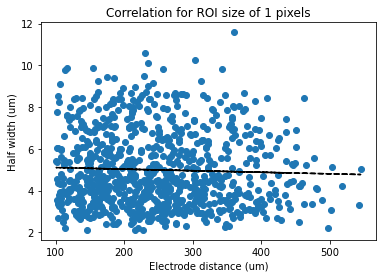

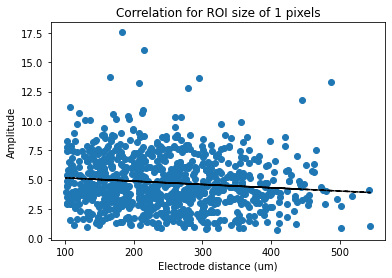

r^2 = 0.01258478207800756
Num points: 1002
[-5.43230800e-04  5.09549492e+00]
r^2 = 0.0006871250590000088


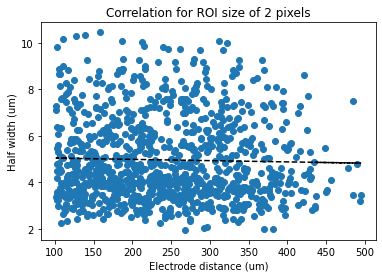

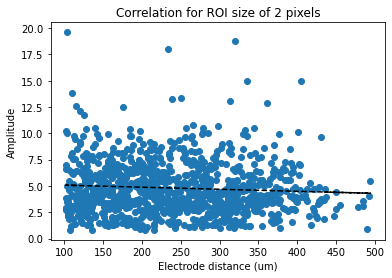

r^2 = 0.0046332561551864875
Num points: 1071
[-5.34540271e-04  4.92124379e+00]
r^2 = 0.0007523975544254498


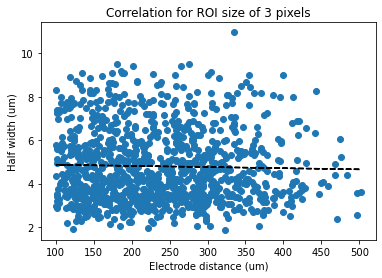

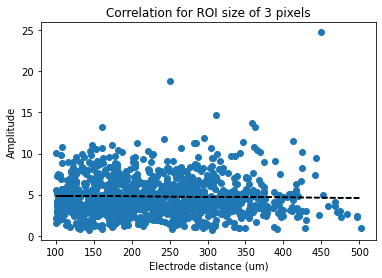

r^2 = 0.000484799215213784
Num points: 1046
[-4.25192407e-04  5.03110676e+00]
r^2 = 0.00044420774944450126


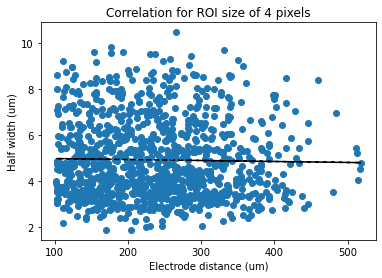

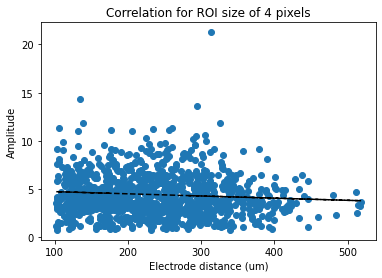

r^2 = 0.007457115393782242
Num points: 1187
[-1.49707133e-03  5.31231652e+00]
r^2 = 0.00540099753056956


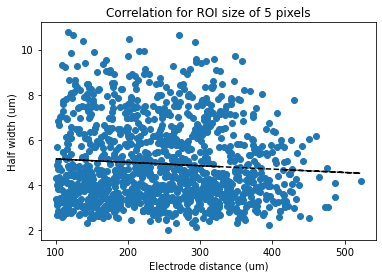

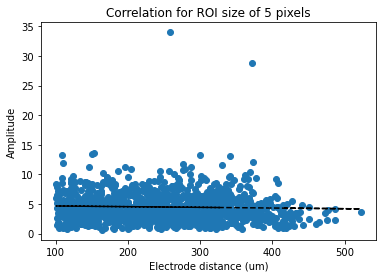

r^2 = 0.0016799957520251994
Num points: 1128
[-6.11046703e-04  5.23267972e+00]
r^2 = 0.0008836200154243694


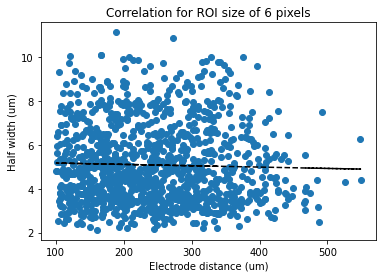

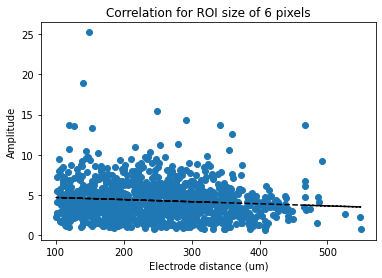

r^2 = 0.010005077562184599
Num points: 1261
[-2.10325729e-03  5.43112626e+00]
r^2 = 0.011162045787008133


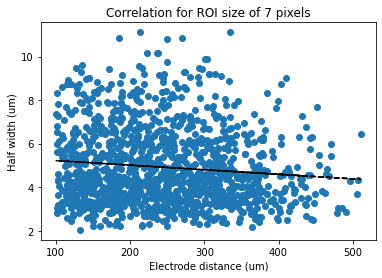

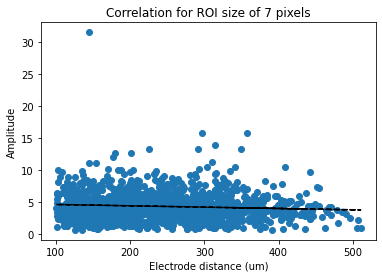

r^2 = 0.006254333532845677
Num points: 1217
[-1.15223793e-03  5.25226366e+00]
r^2 = 0.0033623130007732734


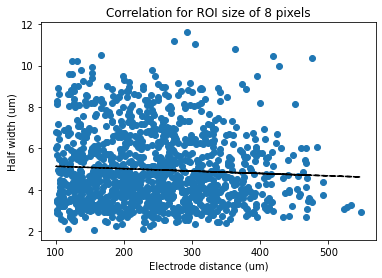

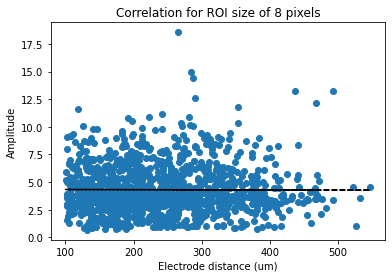

r^2 = 2.9548410257802294e-05
Num points: 1291
[-4.22946045e-04  5.13905450e+00]
r^2 = 0.00044431523789139325


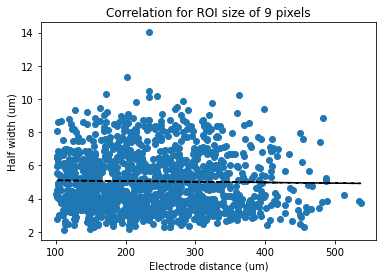

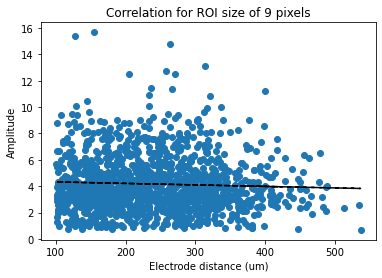

r^2 = 0.0022501788048531917
Num points: 1360
[-1.20655851e-03  5.32026399e+00]
r^2 = 0.0034283065463410227


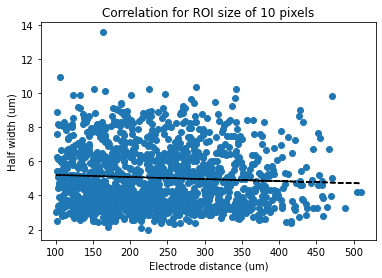

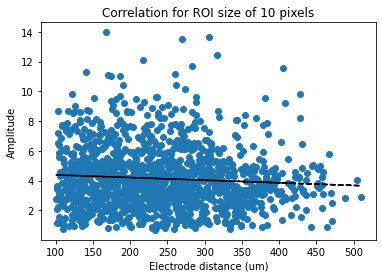

r^2 = 0.005495241298456553
Num points: 1615
[-7.17552234e-04  5.15308751e+00]
r^2 = 0.0012475993707606518


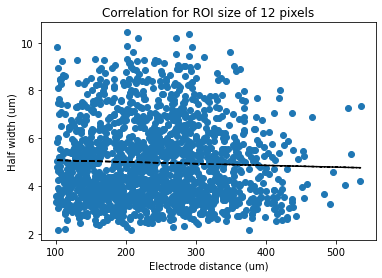

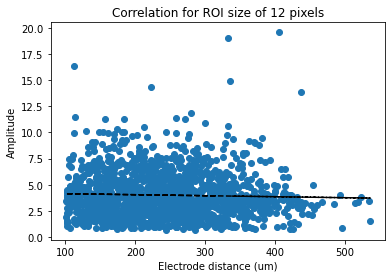

r^2 = 0.0013869740465940552
Num points: 1637
[-7.61048350e-04  5.24533291e+00]
r^2 = 0.0013577856377243163


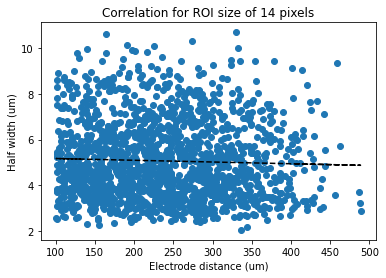

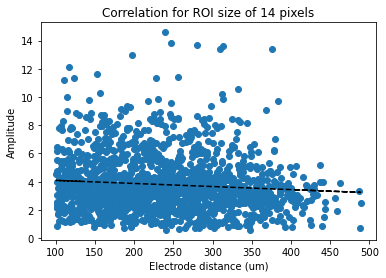

r^2 = 0.008054513673534916
Num points: 0
Num points: 0
Num points: 0


In [48]:
#  BY ROI_SIZE now
slopes = {
    'amp': [],
    'hw': [],
    'r_amp': [],
    'r_hw': [],
    'roi_sizes': []
}
for roi_size in roi_sizes:
    
    df_rs = all_snr[all_snr['roi_size'] == roi_size]
    print("Num points:", len(df_rs['electrode_dist']))
    if len(df_rs['electrode_dist']) < 1:
        continue
    
    # scatter plot: hw vs electrode dist 
    x = df_rs['electrode_dist']
    plt.scatter(x, df_rs['Valuehw'])
    coef = np.polyfit(x, df_rs['Valuehw'], 1)
    print(coef)
    poly1d_fn = np.poly1d(coef) 
    correlation = np.corrcoef(x, df_rs['Valuehw'])[0,1]

     # r
    print("r^2 =", correlation**2)
    slopes['r_hw'].append(correlation**2)
    plt.plot(x, poly1d_fn(x), '--k', label='Slope:' + str(coef[1])[5])
    plt.xlabel("Electrode distance (um)")
    plt.ylabel("Half width (um)")
    plt.title("Correlation for ROI size of " + str(roi_size)
             + " pixels")
    plt.show()
    
    slopes['hw'].append(coef[1])
    
    ### scatter plot: amp vs electrode dist
    plt.scatter(x, df_rs['Valueamp'])
    coef = np.polyfit(x, df_rs['Valueamp'], 1)
    poly1d_fn = np.poly1d(coef) 
    plt.plot(x, poly1d_fn(x), '--k', label='Slope:' + str(coef[1])[5])
    plt.xlabel("Electrode distance (um)")
    plt.ylabel("Amplitude")
    plt.title("Correlation for ROI size of " + str(roi_size)
             + " pixels")
    plt.show()
    
    correlation = np.corrcoef(x, df_rs['Valueamp'])[0,1]

     # r
    print("r^2 =", correlation**2)
    slopes['r_amp'].append(correlation**2)
    
    slopes['amp'].append(coef[1])
    slopes['roi_sizes'].append(roi_size)
    
    

[5.420770642256215, 5.266675488942212, 4.913065081013912, 4.950615222439944, 4.77436208724021, 4.9605162036943184, 4.860688913850534, 4.346083145698983, 4.440570799728787, 4.55841007848791, 4.235530985229968, 4.311241719850937]
[5.178086812423958, 5.095494917775308, 4.921243788191049, 5.031106759356571, 5.312316517880806, 5.232679723834115, 5.4311262570176915, 5.252263662006847, 5.1390545009066875, 5.320263992597853, 5.153087509123442, 5.245332914325932]


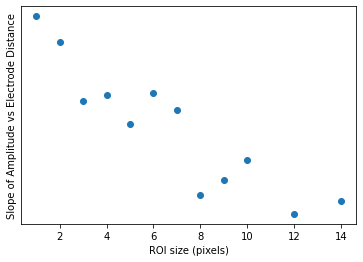

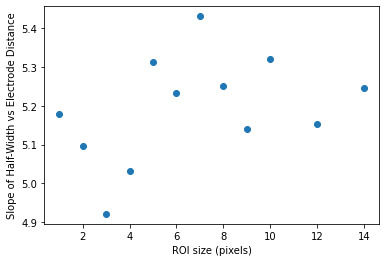

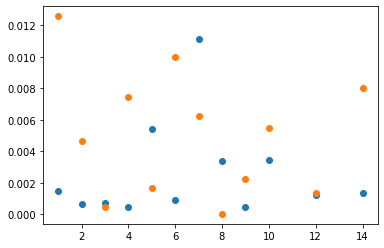

In [51]:
# plot the slopes vs roi_sizes
plt.clf()
print(slopes['amp'])
print(slopes['hw'])
plt.scatter(slopes['roi_sizes'], slopes['amp'])
plt.xlabel('ROI size (pixels)')
plt.yticks([])
plt.ylabel('Slope of Amplitude vs Electrode Distance')
plt.show()

plt.scatter(slopes['roi_sizes'], slopes['hw'])
plt.xlabel('ROI size (pixels)')
plt.ylabel('Slope of Half-Width vs Electrode Distance')
plt.show()

plt.scatter(slopes['roi_sizes'], slopes['r_hw'])
plt.scatter(slopes['roi_sizes'], slopes['r_amp'])
plt.show()